In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from ase.io import read
from matplotlib import pyplot as plt
from tdeptools.kramers_kronig import get_kk_real_from_imag_uneven as get_kk_real

to_invcm = 33.356

In [2]:
def read_dataset(file: str, group="anharmonic") -> xr.Dataset:
    nq = int(xr.load_dataarray(file, group="qmesh")[0])
    ds = xr.load_dataset(file, group=group)
    ds.attrs.update({"nq": nq})
    return ds

In [3]:
# Read the structure
atoms = read("../infile.ucposcar", format="vasp")

# Read the spectral function
ds = read_dataset("../lineshape/outfile.phonon_self_energy.hdf5")

# Read the mode oscillator strengths
df_intensity = pd.read_csv("../lineshape/outfile.ir_intensity.csv", index_col="mode")

# Read the electronic contribution to the dielectric tensor, pick xx component (why?)
data_loto = np.loadtxt("../infile.lotosplitting").reshape(-1, 3, 3)
eps_inf = data_loto[0][0, 0]

df_intensity

,frequency,frequency_cm,loto_split,prefactor,Z_x,Z_y,Z_z,Z_transverse,Z_longitudinal,strength
mode,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,11.892134,396.678892,0.000000,16.576368,0.007309,0.633256,0.000000,0.633298,0.000000,940.211246
4,11.892134,396.678892,0.000000,16.576368,-0.633256,0.007309,0.000000,0.633298,0.000000,940.211246
5,21.139135,705.125644,8.880899,5.246076,0.000000,0.000000,-0.633299,0.000000,0.633299,940.213685


In [24]:
# spectral function = imaginary part of G:

# Which mode are we interested in?
s_mode = 4

# angular frequency:
ws = df_intensity.frequency.iloc[s_mode]

Z = df_intensity.Z_x.iloc[s_mode]

S = Z ** 2 * df_intensity.prefactor.iloc[s_mode]

G_imag = np.pi * ds.spectralfunction_per_mode[s_mode]

# KK to get real
G_real = get_kk_real(xs=ds.frequency, ys=G_imag)

# the full G
G = G_real + 1.0j * G_imag


pref = ws / 2  # makes G(0) -> ~1

# full dielectric function
epsilon = eps_inf + S * pref * G


# Optical functions, compare Eq. (1) in Fugallo2018:

## refraction index
n = np.sqrt(0.5 * (abs(epsilon) + epsilon.real))

## reflectivity r
epsilon_sqrt = np.sqrt(epsilon)
r = abs((epsilon_sqrt - 1) / (epsilon_sqrt + 1)) ** 2

## Absorption
d = 1e-1  # sample thickness, figure out unit
A = epsilon.imag / n
a = A * d
t = np.exp(-a)

# transmission
T = t * (1 - r) ** 2 / (1 - r ** 2 * t ** 2)
R = r * (1 + t * T)

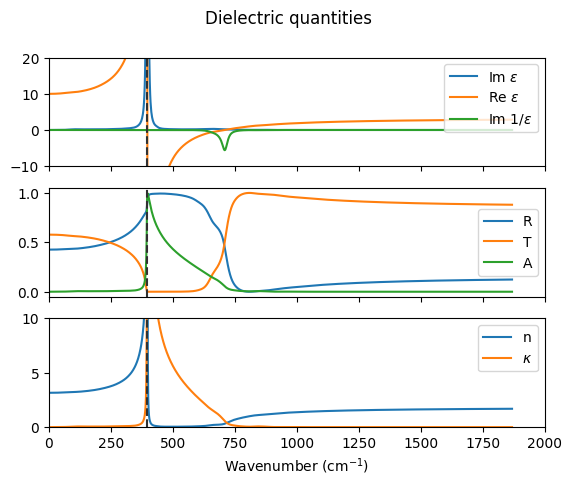

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)

# frequency axis
x = ds.frequency * to_invcm
plt.suptitle('Dielectric quantities')
ax1.plot(x, epsilon.imag)
ax1.plot(x, epsilon.real)
ax1.plot(x, (1 / epsilon).imag)
ax1.legend(["Im $\epsilon$", "Re $\epsilon$", "Im $1/\epsilon$"])
ax1.set_ylim(-10, 20)

ax2.plot(x, R)
ax2.plot(x, T)
ax2.plot(x, 1 - t)
ax2.legend(["R", "T", "A"])

ax3.plot(x, n)
ax3.plot(x, epsilon.imag / n)
ax3.set_ylim(0, 10)
ax3.legend(["n", "$\kappa$"])
ax3.set_xlim(0, 2000)

plt.xlabel('Wavenumber (cm$^{-1}$)')

for ax in (ax1, ax2, ax3):
    ax.axvline(ws * to_invcm, color="#313131", ls="--")